# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Solana cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 125 # approx 8 years
TICKER = "SOLUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR="SOLUSDT:high"
TIME = "SOLUSDT:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2020-08-11 06:00:00,2.85000000,3.47000000,2.85000000,2.95150000,20032.26000000
1,2020-08-11 07:00:00,2.95150000,3.13550000,2.88000000,2.92240000,42069.37000000
2,2020-08-11 08:00:00,2.96260000,3.00000000,2.91440000,2.96000000,24280.76000000
3,2020-08-11 09:00:00,2.96000000,2.97360000,2.85000000,2.85430000,26371.23000000
4,2020-08-11 10:00:00,2.85660000,2.93290000,2.84330000,2.89760000,26685.94000000
...,...,...,...,...,...,...
40078,2025-03-08 16:00:00,137.21000000,137.41000000,135.39000000,136.15000000,155439.01900000
40079,2025-03-08 17:00:00,136.14000000,137.39000000,135.29000000,137.03000000,109140.53600000
40080,2025-03-08 18:00:00,137.03000000,137.94000000,136.62000000,137.75000000,44040.51300000
40081,2025-03-08 19:00:00,137.76000000,138.92000000,137.20000000,138.45000000,53937.32200000


In [3]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,SOLUSDT:time,SOLUSDT:high,SOLUSDT:low,SOLUSDT:close,SOLUSDT:volume
0,2020-08-11 07:00:00,6.234118,-2.422497,-0.985939,110.008107
1,2020-08-11 08:00:00,1.262405,-1.626949,-0.087761,-42.283994
2,2020-08-11 09:00:00,0.459459,-3.716216,-3.570946,8.609574
3,2020-08-11 10:00:00,2.671007,-0.465588,1.435273,1.193384
4,2020-08-11 11:00:00,6.284500,-0.521137,4.559948,-53.254298
...,...,...,...,...,...
40077,2025-03-08 16:00:00,0.145762,-1.326434,-0.772538,121.550590
40078,2025-03-08 17:00:00,0.918172,-0.624357,0.653739,-29.785625
40079,2025-03-08 18:00:00,0.664088,-0.299205,0.525432,-59.647886
40080,2025-03-08 19:00:00,0.842044,-0.406504,0.500871,22.472057


In [4]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data[f"{TICKER}:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data[f"{TICKER}:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

MAX HIGH IN DATASET: 43.16573282217634
OCCURRENCES OVER 0.5: 22547 - PERCENT OF DATASET: 0.5625218302479916
OCCURRENCES OVER 0.6: 19867 - PERCENT OF DATASET: 0.4956588992565241
OCCURRENCES OVER 0.7: 17511 - PERCENT OF DATASET: 0.4368793972356669
OCCURRENCES OVER 0.8: 15533 - PERCENT OF DATASET: 0.38753056234718825
OCCURRENCES OVER 0.9: 13727 - PERCENT OF DATASET: 0.3424729304924904
OCCURRENCES OVER 1: 12133 - PERCENT OF DATASET: 0.3027044558654758
----------------------------------------------------------------------
MAX CLOSE IN DATASET: 30.418755529342366
OCCURRENCES OVER 0.5: 11077 - PERCENT OF DATASET: 0.2763584651464498
OCCURRENCES OVER 0.6: 9779 - PERCENT OF DATASET: 0.24397485155431367
OCCURRENCES OVER 0.7: 8640 - PERCENT OF DATASET: 0.21555810588293997
OCCURRENCES OVER 0.8: 7586 - PERCENT OF DATASET: 0.1892620128736091
OCCURRENCES OVER 0.9: 6713 - PERCENT OF DATASET: 0.16748166259168704
OCCURRENCES OVER 1: 5978 - PERCENT OF DATASET: 0.1491442542787286


In [5]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,SOLUSDT:high0,SOLUSDT:low0,SOLUSDT:close0,SOLUSDT:volume0,SOLUSDT:high1,SOLUSDT:low1,SOLUSDT:close1,SOLUSDT:volume1,SOLUSDT:high2,...,SOLUSDT:volume2,SOLUSDT:high3,SOLUSDT:low3,SOLUSDT:close3,SOLUSDT:volume3,SOLUSDT:high4,SOLUSDT:low4,SOLUSDT:close4,SOLUSDT:volume4,Label
0,2020-08-11 11:00:00,6.234118,-2.422497,-0.985939,110.008107,1.262405,-1.626949,-0.087761,-42.283994,0.459459,...,8.609574,2.671007,-0.465588,1.435273,1.193384,6.284500,-0.521137,4.559948,-53.254298,1
1,2020-08-11 12:00:00,1.262405,-1.626949,-0.087761,-42.283994,0.459459,-3.716216,-3.570946,8.609574,2.671007,...,1.193384,6.284500,-0.521137,4.559948,-53.254298,9.158278,-0.029511,2.013313,996.471931,1
2,2020-08-11 13:00:00,0.459459,-3.716216,-3.570946,8.609574,2.671007,-0.465588,1.435273,1.193384,6.284500,...,-53.254298,9.158278,-0.029511,2.013313,996.471931,5.329476,-7.987785,5.329476,70.368275,1
3,2020-08-11 14:00:00,2.671007,-0.465588,1.435273,1.193384,6.284500,-0.521137,4.559948,-53.254298,9.158278,...,996.471931,5.329476,-7.987785,5.329476,70.368275,7.384024,-6.231128,-0.878397,55.447469,1
4,2020-08-11 15:00:00,6.284500,-0.521137,4.559948,-53.254298,9.158278,-0.029511,2.013313,996.471931,5.329476,...,70.368275,7.384024,-6.231128,-0.878397,55.447469,4.390904,-3.073941,-1.843134,-52.840987,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40072,2025-03-08 15:00:00,0.007229,-1.221716,-0.542182,152.989790,0.588791,-0.668750,0.050883,-28.570552,0.813776,...,37.252354,0.341495,-0.603066,-0.414154,-42.604461,0.466983,-0.715067,0.116746,-3.782626,0
40073,2025-03-08 16:00:00,0.588791,-0.668750,0.050883,-28.570552,0.813776,-0.290634,0.000000,37.252354,0.341495,...,-42.604461,0.466983,-0.715067,0.116746,-3.782626,0.145762,-1.326434,-0.772538,121.550590,1
40074,2025-03-08 17:00:00,0.813776,-0.290634,0.000000,37.252354,0.341495,-0.603066,-0.414154,-42.604461,0.466983,...,-3.782626,0.145762,-1.326434,-0.772538,121.550590,0.918172,-0.624357,0.653739,-29.785625,1
40075,2025-03-08 18:00:00,0.341495,-0.603066,-0.414154,-42.604461,0.466983,-0.715067,0.116746,-3.782626,0.145762,...,121.550590,0.918172,-0.624357,0.653739,-29.785625,0.664088,-0.299205,0.525432,-59.647886,1


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [6]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250308_205222"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.76 GB / 15.92 GB (36.2%)
Disk Space Avail:   178.21 GB / 475.69 GB (37.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [7]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


30077    1
30078    1
30079    1
30080    1
30081    1
        ..
40072    0
40073    1
40074    1
40075    0
40076    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6123,
 'balanced_accuracy': 0.6125034648604841,
 'mcc': 0.22515443801747942,
 'roc_auc': 0.6624394602014394,
 'f1': 0.6175397060274243,
 'precision': 0.6033153430994603,
 'recall': 0.632451000202061,
 'confusion_matrix':       0     1
 0  2993  2058
 1  1819  3130,
 'classification_report': {'0': {'precision': 0.6219866999168745,
   'recall': 0.5925559295189071,
   'f1-score': 0.6069147318260164,
   'support': 5051.0},
  '1': {'precision': 0.6033153430994603,
   'recall': 0.632451000202061,
   'f1-score': 0.6175397060274243,
   'support': 4949.0},
  'accuracy': 0.6123,
  'macro avg': {'precision': 0.6126510215081674,
   'recall': 0.6125034648604841,
   'f1-score': 0.6122272189267204,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6127462454279362,
   'recall': 0.6123,
   'f1-score': 0.6121730315582932,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	117.58s	= Expected runtime (23.52s per shuffle set)
	22.87s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
SOLUSDT:high4,0.01540,0.004543,0.000812,5,0.024754,0.006046
SOLUSDT:low4,0.01260,0.005206,0.002823,5,0.023319,0.001881
SOLUSDT:low3,0.00592,0.006311,0.051976,5,0.018915,-0.007075
SOLUSDT:high3,0.00444,0.004281,0.040611,5,0.013255,-0.004375
SOLUSDT:low1,0.00308,0.002382,0.022241,5,0.007984,-0.001824
SOLUSDT:close4,0.00292,0.004888,0.126276,5,0.012984,-0.007144
SOLUSDT:close3,0.00216,0.000888,0.002770,5,0.003988,0.000332
SOLUSDT:low0,0.00184,0.002985,0.120061,5,0.007985,-0.004305
SOLUSDT:high2,0.00120,0.002421,0.164912,5,0.006184,-0.003784
SOLUSDT:volume3,0.00076,0.002238,0.244955,5,0.005368,-0.003848


In [8]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.422546,0.577454
1,0.355710,0.644290
2,0.389353,0.610647
3,0.338444,0.661556
4,0.374351,0.625649
...,...,...
9995,0.518364,0.481636
9996,0.496096,0.503904
9997,0.486197,0.513803
9998,0.548696,0.451304


,Label
0,1
1,1
2,1
3,1
4,1
...,...
9995,0
9996,1
9997,1
9998,0


,SOLUSDT:high0,SOLUSDT:low0,SOLUSDT:close0,SOLUSDT:volume0,SOLUSDT:high1,SOLUSDT:low1,SOLUSDT:close1,SOLUSDT:volume1,SOLUSDT:high2,SOLUSDT:low2,...,SOLUSDT:volume2,SOLUSDT:high3,SOLUSDT:low3,SOLUSDT:close3,SOLUSDT:volume3,SOLUSDT:high4,SOLUSDT:low4,SOLUSDT:close4,SOLUSDT:volume4,Label
0,1.588115,-0.297131,0.983607,57.504966,2.404627,-0.324675,0.821834,128.955039,1.730905,-0.593741,...,-30.408990,0.059607,-1.102722,-0.695410,-43.079146,0.400160,-0.890356,-0.600240,-5.682730,0
1,2.404627,-0.324675,0.821834,128.955039,1.730905,-0.593741,1.288115,-30.408990,0.059607,-1.102722,...,-43.079146,0.400160,-0.890356,-0.600240,-5.682730,0.301932,-1.469404,-1.388889,35.116787,1
2,1.730905,-0.593741,1.288115,-30.408990,0.059607,-1.102722,-0.695410,-43.079146,0.400160,-0.890356,...,-5.682730,0.301932,-1.469404,-1.388889,35.116787,0.959379,-0.183711,0.479690,-29.858256,0
3,0.059607,-1.102722,-0.695410,-43.079146,0.400160,-0.890356,-0.600240,-5.682730,0.301932,-1.469404,...,35.116787,0.959379,-0.183711,0.479690,-29.858256,0.375787,-1.391428,-1.157831,43.777506,1
4,0.400160,-0.890356,-0.600240,-5.682730,0.301932,-1.469404,-1.388889,35.116787,0.959379,-0.183711,...,-29.858256,0.375787,-1.391428,-1.157831,43.777506,0.647349,-0.842581,0.626798,-10.311384,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.007229,-1.221716,-0.542182,152.989790,0.588791,-0.668750,0.050883,-28.570552,0.813776,-0.290634,...,37.252354,0.341495,-0.603066,-0.414154,-42.604461,0.466983,-0.715067,0.116746,-3.782626,0
9996,0.588791,-0.668750,0.050883,-28.570552,0.813776,-0.290634,0.000000,37.252354,0.341495,-0.603066,...,-42.604461,0.466983,-0.715067,0.116746,-3.782626,0.145762,-1.326434,-0.772538,121.550590,1
9997,0.813776,-0.290634,0.000000,37.252354,0.341495,-0.603066,-0.414154,-42.604461,0.466983,-0.715067,...,-3.782626,0.145762,-1.326434,-0.772538,121.550590,0.918172,-0.624357,0.653739,-29.785625,1
9998,0.341495,-0.603066,-0.414154,-42.604461,0.466983,-0.715067,0.116746,-3.782626,0.145762,-1.326434,...,121.550590,0.918172,-0.624357,0.653739,-29.785625,0.664088,-0.299205,0.525432,-59.647886,1


MEAN PROB 1 CLASSIFICATION: 0.5089558939099312
MAX PROB 1 CLASSIFICATION: 0.919126033782959
MIN PROB 1 CLASSIFICATION: 0.15501730144023895
COUNT OF NUMBERS > 0.7: 971
COUNT OF NUMBERS > 0.8: 155
COUNT OF NUMBERS > 0.9: 3


CORRECT: 758
WRONG: 213
NUMBER OF TRADES: 971
WIN RATE: 78.06%
RETURN: 149.45
INVESTMENT VALUE: 249.45
SHARP RATIO: 3.1522462070851134
SHARP RATIO ONLY HOLDING ASSET: 0.8422280065273813
MEAN RETURN BAD TRADES: -1.3278826291079813
----------------------------------
-0.664
-0.624
-3.059
-1.249
0.159
-0.082
-1.058
-0.519
-1.343
-0.209
-3.247
-2.495
-1.349
-0.67
-2.903
-0.996
-1.577
0.202
-1.277
-2.643
0.348
-1.664
-1.617
-1.758
-1.889
-3.514
0.459
-2.288
-2.787
-0.533
-0.693
-0.347
-1.436
-0.967
-3.029
-0.631
-5.453
-2.229
-0.737
-1.475
-1.108
-3.571
-1.286
-2.015
-2.492
-0.789
-1.686
-1.419
-0.336
-0.746
-1.007
-0.337
0.082
-0.268
-0.797
-0.289
0.23
-1.005
-2.269
-4.293
-6.841
-2.65
-0.4
-0.91
-0.856
-1.902
-1.28
-1.615
-2.174
-0.723
-0.429
-1.841
-1.794
-0.548
-0.527
-2.018
-0.733
-0.353
-1.369
-1.283
0.1
-0.496
-1.536
-0.78
-0.981
-0.603
-0.196
0.023
-0.368
-0.108
-0.174
-0.679
-0.187
-1.744
-0.277
-0.539
-1.505
-0.712
-0.934
-1.27
-2.344
-0.569
-1.894
-1.639
-1.712
-0.092
-3.681
-4.28

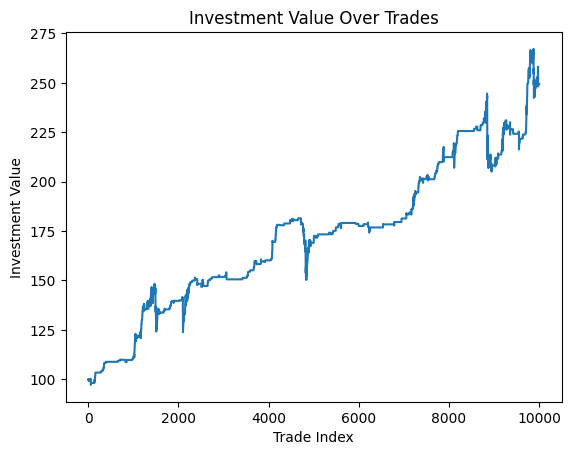

In [9]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset[f"{TICKER}:close4"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [12]:
######################## OLD FILE #################################
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.7
LEVERAGE = 1

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = test_data_frame2["Label"][index]

        true_high = test_data_frame2[f"{TICKER}:high4"][index + 1]
        true_low = test_data_frame2[f"{TICKER}:low4"][index + 1]
        true_close = test_data_frame2[f"{TICKER}:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")

------------------- TRADES: ------------------------------
29786. Gain +5%
29787. Gain +5%
29799. Gain +5%
29800. Close +-1.9687850657961918
29801. Gain +5%
29802. Close +0.16354901359500826
29813. Close +-3.0001027432446334
29814. Close +-2.5312433806396957
29815. Gain +5%
29816. Gain +5%
29835. Gain +5%
29836. Gain +5%
29838. Gain +5%
29839. Gain +5%
29848. Gain +5%
29849. Gain +5%
29854. Close +-3.84449709239715
29855. Gain +5%
29858. Close +-2.4271306660755823
29859. Close +-0.9085746734809734
29860. Gain +5%
29861. Gain +5%
29862. Gain +5%
29863. Gain +5%
29869. Gain +5%
29871. Gain +5%
29874. Gain +5%
29875. Gain +5%
29876. Close +-2.417892403788037
29877. Gain +5%
29878. Gain +5%
29881. Gain +5%
29882. Gain +5%
29885. Close +-1.1705523846377168
29886. Gain +5%
29893. Gain +5%
29894. Gain +5%
29895. Gain +5%
29896. Gain +5%
29897. Close +-1.0009910802775075
29898. Gain +5%
29899. Close +-0.7695382770337758
29901. Gain +5%
29902. Gain +5%
29903. Close +-0.15073861923425352
29917. 

CORRECT: 10
WRONG: 3
NUMBER OF TRADES: 13
WIN RATE: 76.92%
----------------------------------
MEAN GOOD TRADES: 3.1360272250503716
MEAN BAD TRADES: -1.947629885918308
RETURN: 27.862 %


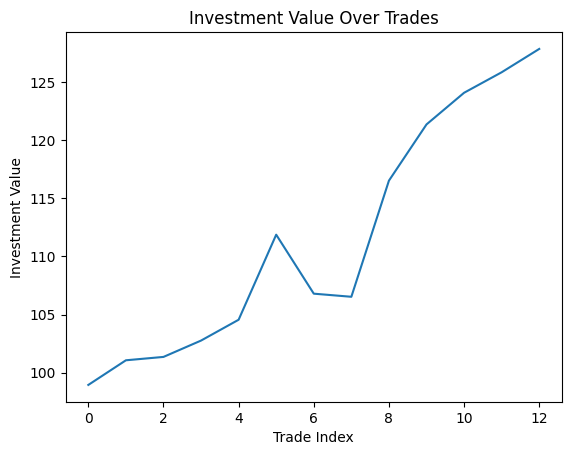

In [19]:
############### ANALYSIS OF NEGATIVE VALUE PREDICTIONS ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.87
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0.25:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()